# Toxic comments

This notebook takes you though a complete iteration of Machine Learning Assignment 1 - Toxic comments. The assignment details (including links to download the data) can be found [here](https://docs.google.com/document/d/1WGYw99e5q6j5V0Zrf2HveagU6URt_kVvdR8B9HYQ99E/edit?usp=sharing). 

In [12]:
# all imports and magic commands
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from my_measures import BinaryClassificationPerformance
from sklearn.feature_extraction.text import HashingVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from scipy.sparse import csr_matrix, hstack
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
%matplotlib inline

### IMPORTANT!!! Make sure you are using `BinaryClassificationPerformance` v1.02

In [13]:
help(BinaryClassificationPerformance)

Help on class BinaryClassificationPerformance in module my_measures:

class BinaryClassificationPerformance(builtins.object)
 |  BinaryClassificationPerformance(predictions, labels, desc, probabilities=None)
 |  
 |  Performance measures to evaluate the fit of a binary classification model, v1.02
 |  
 |  Methods defined here:
 |  
 |  __init__(self, predictions, labels, desc, probabilities=None)
 |      Initialize attributes: predictions-vector of predicted values for Y, labels-vector of labels for Y
 |  
 |  compute_measures(self)
 |      Compute performance measures defined by Flach p. 57
 |  
 |  img_indices(self)
 |      Get the indices of true and false positives to be able to locate the corresponding images in a list of image names
 |  
 |  ----------------------------------------------------------------------
 |  Data descriptors defined here:
 |  
 |  __dict__
 |      dictionary for instance variables (if defined)
 |  
 |  __weakref__
 |      list of weak references to the obj

# Function for feature building and extraction on natural language data

In [14]:
# function that takes raw data and completes all preprocessing required before model fits
def process_raw_data(fn, my_random_seed, test=False):
    # read and summarize data
    toxic_data = pd.read_csv(fn)
    if (not test):
        # add an indicator for any toxic, severe toxic, obscene, threat, insult, or indentity hate
        toxic_data['any_toxic'] = (toxic_data['toxic'] + toxic_data['severe_toxic'] + toxic_data['obscene'] + toxic_data['threat'] + toxic_data['insult'] + toxic_data['identity_hate'] > 0)
    print("toxic_data is:", type(toxic_data))
    print("toxic_data has", toxic_data.shape[0], "rows and", toxic_data.shape[1], "columns", "\n")
    print("the data types for each of the columns in toxic_data:")
    print(toxic_data.dtypes, "\n")
    print("the first 10 rows in toxic_data:")
    print(toxic_data.head(5))
    if (not test):
        print("The rate of 'toxic' Wikipedia comments in the dataset: ")
        print(toxic_data['any_toxic'].mean())

    # vectorize Bag of Words from review text; as sparse matrix
    if (not test): # fit_transform()
        hv = HashingVectorizer(n_features=2 ** 17, alternate_sign=False, ngram_range=(2, 2))
        X_hv = hv.fit_transform(toxic_data.comment_text)
        fitted_transformations.append(hv)
        print("Shape of HashingVectorizer X:")
        print(X_hv.shape)
    else: # transform() 
        X_hv = fitted_transformations[0].transform(toxic_data.comment_text)
        print("Shape of HashingVectorizer X:")
        print(X_hv.shape)
    
    # http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfTransformer.html
    if (not test):
        transformer = TfidfTransformer()
        X_tfidf = transformer.fit_transform(X_hv)
        fitted_transformations.append(transformer)
    else:
        X_tfidf = fitted_transformations[1].transform(X_hv)
    
    # create additional quantitative features
    # features from Amazon.csv to add to feature set
    toxic_data['word_count'] = toxic_data['comment_text'].str.split(' ').str.len()
    toxic_data['punc_count'] = toxic_data['comment_text'].str.count("\.")

    X_quant_features = toxic_data[["word_count", "punc_count"]]
    print("Look at a few rows of the new quantitative features: ")
    print(X_quant_features.head(10))
    
    # Combine all quantitative features into a single sparse matrix
    X_quant_features_csr = csr_matrix(X_quant_features)
    X_combined = hstack([X_tfidf, X_quant_features_csr])
    X_matrix = csr_matrix(X_combined) # convert to sparse matrix
    print("Size of combined bag of words and new quantitative variables matrix:")
    print(X_matrix.shape)
    
    # Create `X`, scaled matrix of features
    # feature scaling
    if (not test):
        sc = StandardScaler(with_mean=False)
        X = sc.fit_transform(X_matrix)
        fitted_transformations.append(sc)
        print(X.shape)
        y = toxic_data['any_toxic']
    else:
        X = fitted_transformations[2].transform(X_matrix)
        print(X.shape)
    
    # Create Training and Test Sets
    # enter an integer for the random_state parameter; any integer will work
    if (test):
        X_submission_test = X
        print("Shape of X_test for submission:")
        print(X_submission_test.shape)
        print('SUCCESS!')
        return(toxic_data, X_submission_test)
    else: 
        X_train, X_test, y_train, y_test, X_raw_train, X_raw_test = train_test_split(X, y, toxic_data, test_size=0.2, random_state=my_random_seed)
        print("Shape of X_train and X_test:")
        print(X_train.shape)
        print(X_test.shape)
        print("Shape of y_train and y_test:")
        print(y_train.shape)
        print(y_test.shape)
        print("Shape of X_raw_train and X_raw_test:")
        print(X_raw_train.shape)
        print(X_raw_test.shape)
        print('SUCCESS!')
        return(X_train, X_test, y_train, y_test, X_raw_train, X_raw_test)

# Create training and test sets from function

In [15]:
# create an empty list to store any use of fit_transform() to transform() later
# it is a global list to store model and feature extraction fits
fitted_transformations = []

# CHANGE FILE PATH and my_random_seed number (any integer other than 74 will do): 
X_train, X_test, y_train, y_test, X_raw_train, X_raw_test = process_raw_data(fn='/Users/toeyscn/Downloads/ml-master/final_assignment_1/toxiccomments_train.csv', my_random_seed=70)

print("Number of fits stored in `fitted_transformations` list: ")
print(len(fitted_transformations))

toxic_data is: <class 'pandas.core.frame.DataFrame'>
toxic_data has 159571 rows and 9 columns 

the data types for each of the columns in toxic_data:
id               object
comment_text     object
toxic             int64
severe_toxic      int64
obscene           int64
threat            int64
insult            int64
identity_hate     int64
any_toxic          bool
dtype: object 

the first 10 rows in toxic_data:
                 id                                       comment_text  toxic  \
0  0000997932d777bf  Explanation\nWhy the edits made under my usern...      0   
1  000103f0d9cfb60f  D'aww! He matches this background colour I'm s...      0   
2  000113f07ec002fd  Hey man, I'm really not trying to edit war. It...      0   
3  0001b41b1c6bb37e  "\nMore\nI can't make any real suggestions on ...      0   
4  0001d958c54c6e35  You, sir, are my hero. Any chance you remember...      0   

   severe_toxic  obscene  threat  insult  identity_hate  any_toxic  
0             0        0     

# Fit (and tune) Various Models

### MODEL: ordinary least squares

In [16]:
from sklearn import linear_model
ols = linear_model.SGDClassifier(loss="squared_loss")
ols.fit(X_train, y_train)

ols_performance_train = BinaryClassificationPerformance(ols.predict(X_train), y_train, 'ols_train')
ols_performance_train.compute_measures()
print(ols_performance_train.performance_measures)

{'Pos': 12994, 'Neg': 114662, 'TP': 6468, 'TN': 58320, 'FP': 56342, 'FN': 6526, 'Accuracy': 0.5075202105658958, 'Precision': 0.10297723292469352, 'Recall': 0.4977682007080191, 'desc': 'ols_train'}


### MODEL: SVM, linear

In [17]:
from sklearn import linear_model
svm = linear_model.SGDClassifier()
svm.fit(X_train, y_train)

svm_performance_train = BinaryClassificationPerformance(svm.predict(X_train), y_train, 'svm_train')
svm_performance_train.compute_measures()
print(svm_performance_train.performance_measures)

{'Pos': 12994, 'Neg': 114662, 'TP': 12974, 'TN': 114638, 'FP': 24, 'FN': 20, 'Accuracy': 0.9996553236823964, 'Precision': 0.9981535620864749, 'Recall': 0.9984608280744959, 'desc': 'svm_train'}


### MODEL: logistic regression

In [18]:
from sklearn import linear_model
lgs = linear_model.SGDClassifier(loss='log')
lgs.fit(X_train, y_train)

lgs_performance_train = BinaryClassificationPerformance(lgs.predict(X_train), y_train, 'lgs_train')
lgs_performance_train.compute_measures()
print(lgs_performance_train.performance_measures)

{'Pos': 12994, 'Neg': 114662, 'TP': 12967, 'TN': 114647, 'FP': 15, 'FN': 27, 'Accuracy': 0.999670990787742, 'Precision': 0.9988445539978432, 'Recall': 0.9979221179005695, 'desc': 'lgs_train'}


### MODEL: Naive Bayes

In [19]:
from sklearn.naive_bayes import MultinomialNB
nbs = MultinomialNB()
nbs.fit(X_train, y_train)

nbs_performance_train = BinaryClassificationPerformance(nbs.predict(X_train), y_train, 'nbs_train')
nbs_performance_train.compute_measures()
print(nbs_performance_train.performance_measures)

{'Pos': 12994, 'Neg': 114662, 'TP': 12758, 'TN': 108946, 'FP': 5716, 'FN': 236, 'Accuracy': 0.9533746944914457, 'Precision': 0.690592183609397, 'Recall': 0.9818377712790519, 'desc': 'nbs_train'}


### MODEL: Perceptron

In [20]:
from sklearn import linear_model
prc = linear_model.SGDClassifier(loss='perceptron')
prc.fit(X_train, y_train)

prc_performance_train = BinaryClassificationPerformance(prc.predict(X_train), y_train, 'prc_train')
prc_performance_train.compute_measures()
print(prc_performance_train.performance_measures)

{'Pos': 12994, 'Neg': 114662, 'TP': 12955, 'TN': 114646, 'FP': 16, 'FN': 39, 'Accuracy': 0.9995691546029956, 'Precision': 0.9987664790686916, 'Recall': 0.9969986147452671, 'desc': 'prc_train'}


### MODEL: Ridge Regression Classifier

In [21]:
from sklearn import linear_model
rdg = linear_model.RidgeClassifier()
rdg.fit(X_train, y_train)

rdg_performance_train = BinaryClassificationPerformance(rdg.predict(X_train), y_train, 'rdg_train')
rdg_performance_train.compute_measures()
print(rdg_performance_train.performance_measures)

{'Pos': 12994, 'Neg': 114662, 'TP': 12976, 'TN': 114652, 'FP': 10, 'FN': 18, 'Accuracy': 0.9997806605251613, 'Precision': 0.999229939935315, 'Recall': 0.9986147452670463, 'desc': 'rdg_train'}


### MODEL: Random Forest Classifier

In [22]:
from sklearn.ensemble import RandomForestClassifier
rdf = RandomForestClassifier(max_depth=2, random_state=0)
rdf.fit(X_train, y_train)

rdf_performance_train = BinaryClassificationPerformance(rdf.predict(X_train), y_train, 'rdf_train')
rdf_performance_train.compute_measures()
print(rdf_performance_train.performance_measures)

{'Pos': 12994, 'Neg': 114662, 'TP': 0, 'TN': 114662, 'FP': 0, 'FN': 12994, 'Accuracy': 0.8982108165695306, 'Precision': nan, 'Recall': 0.0, 'desc': 'rdf_train'}


/Users/toeyscn/Downloads/ml-master/final_assignment_1/my_measures.py:25: RuntimeWarning: invalid value encountered in long_scalars
  self.performance_measures['Precision'] = self.performance_measures['TP'] / (self.performance_measures['TP'] + self.performance_measures['FP'])


### ROC plot to compare performance of various models and fits

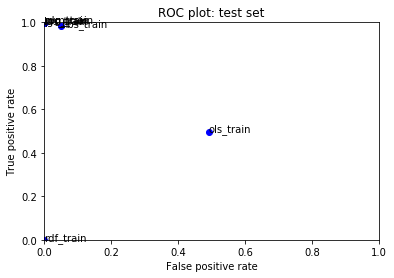

In [23]:
fits = [ols_performance_train, svm_performance_train, lgs_performance_train, nbs_performance_train, prc_performance_train, rdg_performance_train, rdf_performance_train]

for fit in fits:
    plt.plot(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
             fit.performance_measures['TP'] / fit.performance_measures['Pos'], 'bo')
    plt.text(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
             fit.performance_measures['TP'] / fit.performance_measures['Pos'], fit.desc)
plt.axis([0, 1, 0, 1])
plt.title('ROC plot: test set')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.show()

### looking at reviews based on their classification

Let's say we decide that Ordinary Least Squares (OLS) Regression is the best model for generalization. Let's take a look at some of the reviews and try to make a (subjective) determination of whether it's generalizing well. 

### let's look at some false positives:

In [24]:
ols_predictions = ols.predict(X_train)

In [25]:
# false positives

print("Examples of false positives:")

import random, time

for i in range(0, len(ols_predictions)):
    if (ols_predictions[i] == 1):
        if (X_raw_train.iloc[i]['any_toxic'] == 0):
            if (random.uniform(0, 1) < 0.05): # to print only 5% of the false positives
                print(i)
                print(X_raw_train.iloc[i]['comment_text'])
                print('* * * * * * * * * ')


Examples of false positives:
45
Its completely crazy, off the wall nuts, to suggest that Extraordinary Rendition isn't highly illegal. Why do you think the whole of Europe is up in arms about it? Its the biggest scandal I can remember. At the airport near my home, where these poor guys are shipped through in chains, there has been a permanent 24 hour peace camp since 2002. There have been arrests in Italy. German government people have lost their jobs. There's been EU investigations. Resignations, etc. How could kidnapping be anything but illegal?
Imagine in your own country if, China for example, was 'extraordinarily rendering' US citizens from their homes off the street. The Chinese might pass a chinese law to allow it. It would still be illegal in the US.... al  bin Baloney (Hows my driving?)
* * * * * * * * * 
95
It is indeed very real
* * * * * * * * * 
174
Great.  I figured it must just be something like that but wanted to make sure.   17:10, 1 Apr 2005 (UTC)
* * * * * * * * * 
3

1219
My ideas are not against socialism at all, Islam is not socialism, in fact, Islam stands against everything socialism stands for, do you think Muslims tolerate other religions and Atheists and Agnostics while in their countries? Of course not, and I don't care whether I am against multiculturalism, multiculturalism has failed, Muslims hate us, we cannot change that. I am not a racist as well, I am proud to be European, what is wrong with that?
* * * * * * * * * 
1233
The view that it's a part of India is Indian point of view. That's why the dispute exists. Is it that hard to understand?
* * * * * * * * * 
1251
Who did I attack 
Who did I attack?  I simply mentioned that he was retired and frequently commented on American Idol articles.
* * * * * * * * * 
1280
I can confirm I have read WP:SOCK and fully understand it. Once again I can only apologise and hope that you may decide to unblock me.
* * * * * * * * * 
1305
I didn't say anything about finding errors; I referred to readabil

3402
, so I can't do much more myself.
* * * * * * * * * 
3457
"

The determination of reliable sources in relation to determining the scientific consensus is whether or not they are independent, third party sources with no reason outside of scientific validity for coming to such conclusions. That is not the case here, all the studies you've cited ""disproving"" a link have financial ties with the vaccine manufacturers, such as the AAP, the people who did the study in the New England Journal of Medicine etc. The JAMA study in Denmark was done by people with ties to vaccine manufacturer Statens Serum Institut, and omitted 10-25% of Autistic cases in the earlier findings to give the illusion of a constant rate of Autism increase after thimerosal was removed in 1992, even though today the Autism ratio is 1 in 1500 as opposed to 1 in 500 then. The AAP, the website where almost all the other studies are described has considerable ties to the vaccine industry as do Immunization branches of p

5635
Translations that preceded the King James Version were also made from the Greek and Hebrew. I have changed some words that could be taken to mean that the KJV was the first direct translation into English.

It is also worth noting that the KJV is more frank than modern translations. Those who want to find out how much more frank can look up the passages for themselves!  M. Glass
* * * * * * * * * 
5647
"
I doubt Prodego has the time and ability to respond to all your nonsense so I'll explain this: Regarding you wanting to include sources that aren't credible, ""Game Rampage"" and ""Game Rant"", those are more likely to be included if it's sourcing trivial information. You want to use them to source an entire attack piece on this ""Digital Homicide"" group. It's clear you have an axe to grind with your editorializing, but this isn't the place to do it. Controversial sections (Ones that could be considered defaming) have to be sourced much better than sections that are trivial in na

7884
Removal of three names from roster list

I have removed Sean Garrett, Mick Boogie, and Daniel Merriweather as they are not on the Roc Nation website no more and their links to Roc Nation are all broken links.
* * * * * * * * * 
7886
"

True Trips. But User:Zara1709 is appearently from germany, a country with significant nationalism and holocaust history. These guys usually blame all others to be nationalists.

So i will shrink the ""opinion"" of Zara to the 3 real points, which were made:
The significant rising of hinduism in 4th century AD. instead of 2nd c. BC
content about buddhism-related stuff were deleted
Asoka's ""character change"" from converted buddhist to buddhist patronizer

1.) The gupta's were the once, who made hinduism established in northern india. This was done by patronizing the Sanskrit language. Previous religions got lesser attention since then. Gupta's were the Hindu patronizers. So this is the time of the rise of ""modern Hinduism"" in India, which took pla

10026
"
 What ads? I watch Fox8 and I haven't seen a thing. !! a Punk !! "
* * * * * * * * * 
10039
"
 Marx? that's just historic ignorance. Stalin maybe. Now, you have to be very careful with that statement. Superficial statements as ""Many communist organizations and communist leaders were known for their antisemitism"" can be as well stated about religion, blacks, whites, children,... What originally is an economic contradiction is taken as something else, just because it is convenient as anti-communist propaganda. And you know very well how propaganda works. It is a misinterpretation in many cases of what is originally a communism-capitalism problem to be stated as a communism-religious group contradiction. If a religious group (an Jews, Catholics, Muslims,... serve the same as examples) stand in anticommunists stances then, of course, they will get reaction from the communists. The rest is just propaganda, ignorance and opportunistic intentions.  "
* * * * * * * * * 
10059
Please 

12444
"
It's definitely Italian. ""I have not found another place on the internet to tell you..."" There are a few words I don't know, so I can't translate. The second part of the post is the poster's revision of a poem by Pablo Neruda, ""Who dies?"". "
* * * * * * * * * 
12481
I meant that the title isn't mentioned. I will fix that. Crisco added exasperated, but I think that exacerbated what he meant.
* * * * * * * * * 
12605
No problem, mistakes happen and are easily correctable. If you require assistance please let me know; or you can discuss the article on its talk page, Talk:Christian feminism. - Boy
* * * * * * * * * 
12623
"

 On recent edits regarding English section 

I have reverted some edits by Capnprep.  I'll address a few of his concerns:

1.  Do as aspectual auxiliary.  This is the only function of DO as an auxiliary verb and is its primary function within the language.  The non-durational aspects in English (everything not progressive/continuous aspects) are marked by t

15191
"

 Archiving? 

To help keep it tidy, you might want to set up archiving on your talk page. I have archiving on my talk page as well, and it helps me to keep only the most recent messages and questions there. I can help you set the archiving up, if you wish - it only involves the addition of a few tags at the top of the page which you won't be able to see, and after that the archiving is performed automatically by a bot. Just a suggestion, as I thought your talk page was becoming quite long. montecarlo "
* * * * * * * * * 
15289
"

No, Caspian, it is you and your mode of operation that is transparent.

That is the big problem with dealing with Caspian ... if anyone documents what THEY (Caspian blue) do, e.g. create noise as a distraction, they will turn around and use it in their next layer of attack attempting to draw attention away from them.

The prejudicial error in using Google as an arbitrator in a situation like this is that any search for 'Yonsei' will also bring results

17692
Text excised from 2-satisfiability 

This description of the algorithm was included on the page on 2SAT, but was irrelevant there.
I'll paste it here so bits of it could be integrated into this article if required.

Kosaraju's algorithm performs two depth first searches, but is very simple: the first search is used only to order the vertices, in the reverse of a postorder depth-first traversal. Then, the second pass of the algorithm loops through the vertices in this order, and for each vertex that has not already been assigned to a component, it performs a depth-first search of the transpose graph starting from that vertex, backtracking when the search reaches a previously assigned vertices; the unsassigned vertices reached by this search form a new component.
* * * * * * * * * 
17706
How can I delete 

How can I delete
Hello, sorry to bother you, but could you tell how can I fully delete a page. I accidently create two page that are same and while I can remove the material by e

20176
"

 I think the article needs to be changed from 'Bungee Jumping' to 'Bungy Jumping', the proper NZ spelling, since it of course a NZ sport, then redirect from bungee to bungy. (♠ious1♠) "
* * * * * * * * * 
20223
Yes, I got distracted – I'll catch up now.
* * * * * * * * * 
20293
Wikipedia:Appeal Committee
Is this likely to be resurrected, or can it be marked as failed?
* * * * * * * * * 
20301
"

I am still blocked. I see that there are others who have tagged the Jonathan Corrigan Wells article as ""Unbalanced  article is almost entirely from the perspective of critics"". Others have removed the tag. I agree that the article should be tagged. It is very unbalanced. "
* * * * * * * * * 
20362
"

 Ways to improve Chudinov Nickolay Konstantinovich 

Hi, I'm Helenabella. Tchuser, thanks for creating Chudinov Nickolay Konstantinovich!

I've just tagged the page, using our page curation tools, as having some issues to fix. Hi there.  Thanks for your work.  It would be very helpful if

22534
31 January 2007
* * * * * * * * * 
22579
:Thanks for approving me, but i've a problem: Everytime I press Verify Authorization the program 
says Your are not on the User list. How can I fix this error?!
* * * * * * * * * 
22612
"
 Thanks for noticing. Just to be clear, no apology to that editor will be forthcoming. I think I demonstrated tremendous restraint under the circumstances. Where is that editor's warning for his Wikipedia:Wikilawyering? For Wikipedia:WikiBullying? For Wikipedia:POV railroading? I mean, fair is fair. ''''Let's talk about it "
* * * * * * * * * 
22673
"
My sincerest apologies. Well, you won't have to worry about that this time I suppose. Hmmm, maybe you'll do it then. ♥♥Vampire♥Heart♥ "
* * * * * * * * * 
22681
January 2011 (UTC)
 No comments. But I would like to point out that my opinions are based on articles and academic sources whereas yours are plain personal opinions.  01:22, 6
* * * * * * * * * 
22692
I have requested mediation here. https://en.wikip

24636
"

OK then, but don't call it the citizens-initiated referendum, corporal punishment or smacking in the title seems good (I know it's not the ""anti-smacking"" law, but 'smacking' is the subject of the question).   "
* * * * * * * * * 
24735
at time of liberation
* * * * * * * * * 
24780
The change is seamless. All redirects are being fixed (including quite a few that were missed by people when these were moved in the past). We get these in dribs and drabs over at WP:RM, a few a week. Easier to just clean them up. As for projects, they do not overrule the policy of WP:NAME and Wikipedia:Manual of Style (infoboxes)#Design and usage. Standardization is a good thing. We will continue to grow; these boxes will be used in the future and changing them means when we reach 6 million articles, the future ones that would have used the prior name will use the proper name. Moreover, when people seek to create new infoboxes, just as often or maybe more often they do not learn what the title s

27134
"

dude. you're generation X and you watch buffy the vampire slayer. you must be a real hit with the ladies.

and sinneed, you're only helping my cause of proving you ""editors"" are nothing more than popularity contest judges. so thanks!"
* * * * * * * * * 
27309
"

Oh! Shoot. Please forgive my ignorance.  Talk Contribs "
* * * * * * * * * 
27316
Needed images  

Images of Charaka, Sushruta or Vagbhata would be highly appreciated for this article. Also images of some of the Ayurvedic drugs / preparation process photos would also be suitable for this article. Please add these if someone has these photos. Thanks.
* * * * * * * * * 
27347
"

 Prosecutorial Career Section 

This section is only 75% left-wing criticism and ""claims"" of impropriety.  This is unacceptable, it needs to be 90%.  Who cares when he was elected or how many cases he prosecuted?  These are just boring facts.  What we need are more claims of impropriety and maybe some reportage from the Daily Kos to balance o

29376
I figure you were probably monitoring the article and noticed by now, but I wanted to let you know that I posted a section about Hamzah in the Syrian Uprising article a day and a half ago or so.  When I finished, I had a splitting headache and had to log off but I wanted to be sure and let you know.  If this does take the situation there to the next level, and people there are still demonstrating in his name in a couple of weeks, or stage a continuing demonstration as they did in Tahrir Square, we can expand it into its own article.

The day after I wrote you last, I woke to the news that Will Norton's body had been found, after six days.  The whole week his family had been appealing for any word about him, and they kept showing his photo on the news.  He had been driving home from school with his father in the car and his mother had taken her own car.  They were only a few blocks from home when the Joplin tornado hit.  It picked the vehicle up and rolled it several times and his

31914
Manic Street Preachers can't possibly be classified as Britpop, not that it isn't British and not that it isn't pop, but it simply doesn't fit in with the kind of music Blur and Pulp and Suede make.
* * * * * * * * * 
31957
"

 A brownie for you! 

  Hi CJKAllstar! I just wanted to drop by from the Teahouse and bring you a fresh wiki-brownie and say hi! How is your Wikipedia experience going? See you around!   "
* * * * * * * * * 
31962
(UTC)

But what is it with you the protesters and your inability to help yourselves?

Indeed, some of you have a PhD in molecular biology, some have several science degrees. For such a person it should be an execise of several hours (well, maximum, several days), to take an appropriate book (or two), to learn what the expected value is, to return here and make this page satisfactory! Instead, you complain during years. During this time some of you that had no appropriate education at the time of the initial complain should get such education. But 

34476
User:Communist 

FYI (not an April Fools Joke) someone has removed the Tfd tag from Template:User_Communist. Does that end the nomination process somehow? Gosh, that's easy. I'm sorry, but is that box immune from nominations for Tfd, while so many others are not, and have been speedy deleted (rightly so, I believe?) Guess so. I get more educated about Wikipedia bias every day.
* * * * * * * * * 
34522
"

 Sorting doesn't work 

I removed the ""sortable"" option from the table, because it does NOT sort the counties by GDP correctly. The sorting is COMPLETELY messed up."
* * * * * * * * * 
34585
Naveen Sankar, or Austin Maxwell, or Insvik you continually revert the work of others. Such actions do not conform to Wikipedia policies, nor do your multiple usernames. If you do not desist from your repeated course of actions aforementioned, I will report you to an Wiki administrator. Edit wars are not permissible. Further, your preference for the article excluding my edits seem to indica

36850
Bias for what? I'd take the distinguish off any page. It makes no sense. You're distinguishing two distinct fictional characters who share a fictional skill. Do you understand how crowded the hat notes would be if we listed every fictional archer because people might momentarily mistake them for each other? -
* * * * * * * * * 
36896
From Keilor Downs Secondary College
* * * * * * * * * 
36924
" 
 http://www.google.com/search?q=""browser engine"" AND ""CSS 3 support"" -wikipedia -site:wikipedia.org (27,600 items)
 http://www.google.com/search?q=""layout engine"" AND ""CSS 3 support"" -wikipedia -site:wikipedia.org (64,400 items)  "
* * * * * * * * * 
37031
And the administrators who back them up just make things worse.
* * * * * * * * * 
37055
in serious danger of going extinct in the long term
* * * * * * * * * 
37097
What you are refering to as an autoflower is actually ruderalis which flowers like this normally crossed with an indica. The flowers these plants produce are high 

39344
"
Surname: Podd
This very unusual name is of English medieval origins, of which it has two, both quite separate. The first is a variant of the surname Pott. This is either a shortened form of the medieval given name Philpott, from the popular name Phillip, meaning ""lover of horses"", or is residential or locational, and describes a person who lived by a depression in the ground, or who came from a place such as Potcote in the county of Northamptonshire, or Potsgrove in Bedfordshire. The change in spelling from ""tt"" to ""dd"" is a common one and due to regional and dialectual differences as well as careless spelling. Another possible explanation is that it is a variant of Poad, a surname which means 'toad', and was a nickname surname for a person who was thought in someway to represent this animal. The church records of the Southwold Independent church in Suffolk records the baptism of James Pott in 1741 and of Elizabeth Podd in 1757. The first recorded spelling of the family n

41719
You're right Joseph.. You asked me a question  whether I am a paid editor? Actually, you question came around 11pm my time. I was already on bed and saw that via my phone. I have to quickly come online to respond. Well, I've also  responded with the same sincerity on those pages dominated for deletion. But sincerely, Joseph, you were so much in hurry to deal with me. It made to cry...I'll try and follow the terms on disclosing my paid status since it's not a crime to create wiki articles for payments. Thank u.
* * * * * * * * * 
41735
Right, if it were advertising, some of us would be getting paid.
* * * * * * * * * 
41741
Wow. Didn't mean to start a war.  Sorry,
* * * * * * * * * 
41798
Kristof the problem here is a lag from the old Ukrainian orthography that has since changed. A similar case existed in Belarus, but much more amplified, when the changes of 1930s and subsequent orthographic reforms were very noticeable it affected the way whole cities were spelled. Example Minsk 

44096
"
Yes they have, great work! I'll give a full review in the next day or so, and will likely put the article on hold for a week thereafter. the skomorokh "
* * * * * * * * * 
44121
Thank you Squiddy! (but I still think it will get reverted just because I'm a sceptic!).
* * * * * * * * * 
44144
"

ROFL, I just saw this page and was about to post this same thing but you already said it. I've never heard it called ""CM"". Maybe it's a British thing.  "
* * * * * * * * * 
44183
No problems Pete. I have emailed you regarding this. We're both interested in the same clan here and the references from this region are few and far between. Unfortunately many of these 'bigot' have a good chunk of it, but it's important to review it as you have said to establish the truth as opposed to agendas and rhetoric. Hopefully we can work together on this and shed some more light on this fascinating history.
* * * * * * * * * 
44262
"

what have I done to get blocked? the only page I've really contribut

46280
You have mentioned lack of consensus. I say that unreferenced claims must be removed as described in WP:CITE. Who disagrees? Nobody? Consensus reached. Why did you revert my edits?
* * * * * * * * * 
46383
"If trivial information is deemed relevant because it's cited and there is a source for it, why not include Obama's ties to Bill Ayers on his Wikipedia page?  The ""Brown Noser"" theory has already become a Daily Kos, left wing talking point, it should be removed only for the fact that liberals would like to make that a focus and distract from the real issue that Paul Ryan is at odds with the President regarding how exactly medical reform will be paid for.

"
* * * * * * * * * 
46423
Your personal attack is noted
* * * * * * * * * 
46427
Sometimes research is fun. Check out the last sentence here. Can you imagine, a little thing like death getting in the way of one's carreer? 
 -
* * * * * * * * * 
46429
I have edited this article as i thought it was expressing to strongly th p

48890
To the attention of mr. W. Waggel s.s.t.t.:
* * * * * * * * * 
48892
Sorry i've written this bevore looking at your work of today. I like your lists very much, don't change them hastily.  22:40, 13 Aug 2004 (UTC)
* * * * * * * * * 
48945
, 9 November 2010 (UTC)

 Thank you Domer48 for bring this to our attention. Perhaps it is time that this is enforced. I doubt any further arguement will occur until tomorrow, (As I have a hunch; from previous days and weeks, that Factocop may not have internet access from home at the moment.)   17:47
* * * * * * * * * 
48971
"

Take Swift Stern Action against this guy

Hi Sue,

Long time. How are you?

I visit wikipedia only occasionally these days.

I just came across this: 

I think you should give Crossmr a stern warning of NPA and CIVIL on his talk page and I think you should remove that despicable PA and uncivil comment(check out the heading/edit of the comment /edit summary /etc.) from royaa's talk page. Or let me know if I should personal

51389
Please refer to this message. If you're going to accuse me of sockpuppeting then you have an obligation to follow through with it. Otherwise this is merely harassment, which you have a documented history of as well.
* * * * * * * * * 
51447
No, I'm not an admin, but you can find one or several at WP:AN.
* * * * * * * * * 
51532
Note I just had a quick search on Commons, Flickr and Google images and could not find any.
* * * * * * * * * 
51543
"2011]]
}}
 If you post a message on this page, I'll reply here to avoid fragmenting the discussion. So add it to your watchlist;
 If I leave you a message on your talk page, it will be added to my watchlist. So feel free to reply to it there instead of here; 
 Please sign and date your message by typing four tildes (~~~~).
Fragmented conversations hurt my brain.|-
|I will respond here to comments that are posted here, and, well, elsewhere to comments posted elsewhere. Please, please don't fragment a conversation just to get my attention—if 

53888
"

Look, buddy. You need to stop trolling. Add your e-mail on a billboard for all I care. Just don't put it on my talk page. I won't be e-mailing you anytime soon! ←Signed:→Mr. E. Sánchez '''''' / Talk to me!←at≈:→ "
* * * * * * * * * 
53926
1. Okay
 2. Not entirely sure how to do so, but I will read into it. At the worst can I just create a new account?
 3. No. I will not agree to this. I find this completely biased and illogical. The only point of reference the Actual Student Newspaper The Gauntlet uses is ITSELF. You are asking me to go above and beyond what you've previously deemed to be fair. This is not fair, and I ask that you either remove the Gauntlet page (unless you can find  secondary sources as you are asking me) or you allow the 2 sentence subsection to stay.
* * * * * * * * * 
54126
Article Feedback deployment
Hey Ntsimp; I'm dropping you this note because you've used the article feedback tool in the last month or so. On Thursday and Friday the tool will be down fo

56512
"

Have a read of WP:BLOCKNOTPUNITIVE and WP:CIR. '''''' Dick Laurent is dead "
* * * * * * * * * 
56619
"

 ""A side project ""??? 

What the heck is ""a side project""? Is that a definition suitable for an Encyclopedic article?   "
* * * * * * * * * 
56666
He has risen indeed.
* * * * * * * * * 
56728
"
Welcome to Wikipedia!

Hello, , and welcome to Wikipedia! Thank you for your contributions. My name is . I just wanted to say hi and welcome you to the free encyclopedia anybody can edit. If you have any questions about Wikipedia, feel free to leave me a message on my talk/chat page or by typing {{helpme}} at the bottom of this page. Here are some pages to help you. The left column contains tutorials and introductory pages while the right shows ways to help out Wikipedia.
    Introduction
  5    The five pillars of Wikipedia
    How to edit a page
    Help
    Tips
    Manual of Style 
   Write an article
   Fight vandalism
   Improve illustrations and upload new images
   Perfo

59315
PS: Oh yes and I see that foul bio box has a reference here - why don't you vote to get rid of it here .  | talk
* * * * * * * * * 
59377
"

 Pro-Gay Bias? 
To be honest, I am not sure I entirely follow. What is exactly is meant by holding a ""pro-gay bias""? That I am in favour of homosexuality? This seems entirely nonsensical, and indeed strictly speaking to be ""pro-gay"" would mean you hold that it is a superior sexual orientation that all should aspire to. To be quite honest, I think the whole notion of a ""pro-gay bias"" is entirely homophobic, and used to paint those who accept different sexual orientations in a manner that suggests they desire to promote homosexuality. Clearly, the article has a distinctly homophobic bias. It portrays a homosexuality as abnormal and deviant, homosexuality as a ""post-industrial"" cosmopolitan lifestyle, and homosexuality as the social norm. These are all strongly homophobic POVs which are rejected by those who accept different sexual orie

61563
Does this have to do with turtles?
* * * * * * * * * 
61590
me for no reason, this user appears to be acting as a rogue admin and abusing their powers. I would appreciate if another admin could look at this.
thank you
* * * * * * * * * 
61621
Yeah, I forgot a / symbol, anyhow... since I'm against removing stuff in Talk just mentioning it's fixed now...
* * * * * * * * * 
61738
Battle of Cannae-New maps 

Hi these are the new maps for battle of cannae.

As daly mentioned that initially the front of Hannibal was straight line, but became a crescent shaped once hannibal took farward the regiments from his center. The african infantry at the flanks was deployed in a the form of columns to facilitate the maneuverability of its men in order to encircle the Roman flanks.

Hannibals cavalry engaged with the opposing cavalry at the wings while hannibal led the regiments from his center, farward to the romans, thus forming a crescent shape front.

Cavalry at roman's right flanks attacked a

63610
PROBLEM 

it needs a picture
* * * * * * * * * 
63625
2005 (UTC)

  15:59, 17 December
* * * * * * * * * 
63634
Hello, 188.115.16.247, and welcome to Wikipedia! Thank you for your contributions. I hope you like the place and decide to stay. Our intro page provides helpful information for new users—please check it out! If you need help, visit Wikipedia:Questions, ask me on my talk page, or place {{helpme}} on this page and someone will show up shortly to answer your questions. 
Please note I've added a bit more about Noreen Riols though I'd never heard of her before. Happy editing!
* * * * * * * * * 
63676
Progressive Party
I've reverted your additions to Progressive Party (United States, 1912) because you haven't provided a reliable source for your statements about Cecilia Toro. Until you do, those statements will not stay in the article. Given that no such person is listed as a Resident Commissioner of Puerto Rico, I suspect you're perpetrating a hoax. If you aren't, I suggest y

66172
"

 Semi-protected edit request on 4 January 2014 

 ethiopian/eritrean languages/people (ge'ez,amharic,tigre,tigrinya) DID NOT come from yemen. Please change it. 
remove ""originate fom yemen"" 

108.202.145.14  "
* * * * * * * * * 
66175
The sources tend to indicate that his being African-American, and the fact of his being the first, are of great (one could say monumental) importance in American politics.  It's not really a question of whether one agrees or not.  In a perfect world it would not be a big deal, and people would see him simply as the President... or could mention race as an interesting cultural characteristic like being left-handed or a basketball fan.  But the world is not perfect, and his being the first black president of America represents a historical shift in race relations.  Perhaps ten years from now societal mores will change and it will not figure so prominently.  Wikipedia as an encyclopedia is a product of its times, and inasmuch as it draws on source

68397
Notable Townsvilleans 

Nathan Burgers - Goal Keeper for the Australian Mens Field Hockey Team122.109.134.110
* * * * * * * * * 
68498
I taken it to the talk page. Happy?(  )
* * * * * * * * * 
68538
I'm a long-time WP user. And i absolutely know that nothing will happen if i start a discussion. Pure experience, dude. They revert, but they never discuss.
* * * * * * * * * 
68542
source. You don't always need a source
* * * * * * * * * 
68581
"
That's fine; if we have the math we can add it in a note and use these sources to back up the facts. We may also need a source to verify the math. podous "
* * * * * * * * * 
68590
"::Last message. Your ""logic"" is faulty (see above). I have made a cogent argument. The article is also not just about you. You, however, have made this personal - I find your comments to be inflammatory and have ceased working on the article due to your personal comments. I have better things to do with my time than respond to your attacks. Also, you are not a

70610
Request for arbitration of Ireland article naming dispute 

I have filed this Request for arbitration of Ireland article naming dispute and named you as one of the involved parties. I would appreciate it if you could make a 500-word-or-less statement there.  ·✆
* * * * * * * * * 
70687
If wikipedia does not allow rumours or news then how come the majority of articles on tv series, films, music etc are filled with rumours and news on upcoming storylines, characters, release dates, singels, albums etc????????
* * * * * * * * * 
70703
thanx great word s it helped me with my P.E SBA 
'''
* * * * * * * * * 
70789
DON'T MERGE GUTTERPUNK! 

Whatever is decided about 'Streetpunk' and 'OI', none of this is relevant to the 'Gutterpunk'entry. The 'Gutterpunk' article will be expanded and corrected as social science research takes its course. 'Gutter punk'or 'gutterpunk'(it is not yet clear whether or not the space will make a difference) as referred to in the article has nothing whatsoever 

72870
"

AFDs
Don't forget this tag on the AFD subpages: {{subst:afd2 | pg=PageName | text=Reason why the page should be deleted}} ~~~~.  It's what makes the headers on the log page.   "
* * * * * * * * * 
72879
Ready for that block 

Based on the 68.217.248.180's last edit summary, I think he's about ready for a long block. Also, he gave what looks to be a real phone number in an edit summary earlier, that'll probably have to be deleted.  | Talk•Contribs
* * * * * * * * * 
72950
"

Whether waterboarding qualifies as torture has been established on a multitude of sources. Gnothi seauton "
* * * * * * * * * 
72964
"
Seksen the 10,000 turkish-cypriots who were protesting a few months ago (see this) were not protesting against the world (no country imposed any embargoe on North Cyprus). The protests were aimed at Turkey and the imposed austerity measures and the fact that they want to be independent and manage their own affairs. So effectively they feel they're not independent but under o

74969
Dylan is wrong, he owes Fletcher $30.
* * * * * * * * * 
75031
Thanks for the experimentation at Creationism, but if you try that again, you might be viewed as a vandal, and there mght be consequences. Fair enough?
* * * * * * * * * 
75086
Most sources list the film as sci-fi;
* * * * * * * * * 
75091
Warning 

There is clearly a protectionist regime going on here and a witch hunt to boot. The duck rule has been abused to effect this. The article Jonathan Mitchell isn't promotional as that IP that is NOT me claims. It's not notable. As I have been blocked for false reasons, I give notice that I am consulting my lawyers for slander by the blocking admin and reviewing admins. Delete the Jonathan Mitchell article. He's not notable. I maintain that I have not socked but you lot refuse to believe the truth. Well it will likely be sorted out in a court room now. You can re-block this account for legal threats if you want. I will not be slandered and if making the warning is blockable c

77424
"

Disambiguation link notification for May 5

Hi. Thank you for your recent edits. Wikipedia appreciates your help. We noticed though that when you edited List of heliports in Canada, you added a link pointing to the disambiguation page Covenant Health (check to confirm | fix with Dab solver). Such links are almost always unintended, since a disambiguation page is merely a list of ""Did you mean..."" article titles. Read the  Join us at the DPL WikiProject.

It's OK to remove this message. Also, to stop receiving these messages, follow these . Thanks,   "
* * * * * * * * * 
77453
"
I would add some of the text already in the history section such as McKinsey's death. Reference ""ninetytwo"" metadata is not in the draft even though it's called a few times.    "
* * * * * * * * * 
77475
board of trustees meeting
* * * * * * * * * 
77503
Wow, that's ALOT. More than the casualties in WW2.User:Pic Business
* * * * * * * * * 
77560
"

""What was cleverly inserted instead""
Thanks for a

79866
Tenebrae, I am sure the Jewish people can, much as myself, speak for themselves and do not need you as a spokesperson as you generalize the position of the Israelites (you use the terms interchangeable with Jewish but they do not mean the same thing either, incidentally).
* * * * * * * * * 
79975
"
""Episode"" is alarm. -Peter 

The next set is"
* * * * * * * * * 
80063
PS: I like your rewrite of the lead. And so does Jossi! So your prejudgment of his reaction was WRONG. Do you think he would have responded as approvingly if he saw the remark that you aimed at him (the one I deleted)? Please LEARN from this experience!

Please feel free to delete this topic from your talk page after you have read, and preferably absorbed it. It needn't, and probably shouldn't, remain public.
* * * * * * * * * 
80073
and his accolites/group members
* * * * * * * * * 
80134
do we discredit all sources which have made errors, because if so, there's a certain frequently-cited columnist we will need t

82400
His name is Joseph 

His name is Joseph, not Josef! 

http://www.vatican.va/holy_father/benedict_xvi/index.htm
* * * * * * * * * 
82419
"::::Well, that's what I meant, really. The edit summary listed the archive page, but it wasn't a link.  I'm thinking there might be code missing. It doesn't make sense. And it's probably something obvious. The page exists, so why is it not a link in the bot contribs? ''''''Love 

"
* * * * * * * * * 
82446
"

This discussion page may contain comments better considered as trolling, posted in order to prompt irate replies that can then be even further ridiculed, in turn. Before you post any reply, consider how you might minimize the effects of trollish comments. Simply ignoring certain comments may be the best option.

This discussion page may contain comments better considered as trolling, posted in order to prompt irate replies that can then be even further ridiculed, in turn. Before you post any reply, consider how you might minimize the effect

84844
I disagree, and you're going against consensus:  two editors besides myself have edited to the original version.  I'm going to change this back.
* * * * * * * * * 
84906
Look at this, further examples, of this user ():

Wikipedia guidelines ask you to use the edit summary; the template that I used is a standard one, not created by me. The same applies to policies and guidelines such as WP:CITE and WP:CIVIL. Your behaviour here is poor, you response to advice and criticism particularly so. If you can't or won't understand what it is to edit here, with other people rather than pitted against them, you'll find it an unpleasant and frustrating experience. If you're prepared to learn, and to edit reasonably and responsibly, in line with our policies and guidelines, then you'll find it rewarding and enjoyable. It's entirely up to you, of course. Mel Etitis (Talk)  

Everything that has a beginning must have an end.
* * * * * * * * * 
85016
"
Kunstler explained why he called the ""PRT g

87215
I really had to calm down to not curse you out. Get out of my talk page. NOW!
* * * * * * * * * 
87227
Please stop your disruptive editing. If your vandalism continues, you will be blocked from editing Wikipedia.  71.185.178.83
* * * * * * * * * 
87351
Again, a personal assertion with no reliable sources backing it up. Would it help maybe if I gave you examples of reliable sources that question the DH?
* * * * * * * * * 
87356
It might be historical and important, but is highly controversial also, and does not deserve to be part of the first paragraph of the lead. As I said, first paragraph should state the obvious and most common interpretation: Hindu is a follower of Hinduism; just like the other similar pages: Christian (follower of Christianity), Buddhist (follower of Buddhism), etc.
* * * * * * * * * 
87388
"

 Peter the Roman 

Can some one place this and remove the Argentinian Chap from the Prophecy which is not part of, and replace it with this information, and place his 

89641
Suggestion
REFERENCE ENCYCLOPEDIA DRAMATICA IN THE FILM!! 

We need some way to make ED notable, this film is our list hope. We must reference ED!
* * * * * * * * * 
89679
vandalism caused by trolls.
* * * * * * * * * 
89709
=Nordicism
Then how do you explain the fact that to be in the Waffen SS you had to prove your Aryan lineage going back 5 generations and the fact there were not only Nordics but also many Slavs and Mediteraneans in it.
* * * * * * * * * 
89733
"

 Rankings in lead 

Recent good faith edits to the lead regarding rankings  removed some existing text about various  rankings while adding reference a new ranking that was incorrectly attributed to Newsweek instead of Financial Times.

Furthermore, this information in the lead becomes out of sync with detailed rankings in the Rankings section (which was already out of sync even before the aforementioned edits).

Based on guidelines for into text to ""summarize the most important points covered in an article"", I wil

92111
Ran article 

I understand you copyprotected the Tsukikage Ran.You have every to do so of course, but you could have waited until I had undone what was clearly a case of vandalism in my opinion.I apologize if I upset you with this,but I thought I should bring this to your attention.-
* * * * * * * * * 
92143
"As it turned out I was right, because during your alleged ""absence"" (and mine too, as you had me blocked and then autoblocked by you), you continued editing without stop. So yes, it was a trap that repeats for the second weekend now. I clearly stated two weeks ago that I have more time during weekends, so you are trying to kick me out of game every weekend and use that time to make so many changes to my articles that any attempt by me to clear the articles up must be perceived by an outside viewer as vandalism (too many reverts).  

"
* * * * * * * * * 
92265
I'm sure they are all sockpuppets. It CAN'T be possible that several people share the same viewpoint, can it?
* * *

94554
"The point of this page is to discuss and achieve consensus about what should go in the ""Counterpoint"" article, not to answer general questions about counterpoint, and by now I think we've strayed much too far afield. Nevertheless: Yes, a contrapuntal duet for a single violin and a single cello remains just as contrapuntal if the violin part is assigned to a violin section and the cello part is assigned to a cello section. Within the sections, of course, there is no counterpointunless someone is flubbing his part; then we have what I call random counterpoint. 

""I think of a voice as a computer-generated sound that has, in its attempt to simulate a music instrument, a specific waveform and sound envelope, and does not otherwise vary greatly (beyond a particular range of amplitudes and frequencies) from second to second, or minute to minute, in a song."":

This is a dumbed-down abuse of the term promulgated by commercial electronic keyboard manufacturers in order to maximize sa

97053
Have you ever heard of Monaco? Liechtenstein? Luxembourg? Malta? The idea that areas of a few hundred thousand people are too small to be independent is ridiculous. You mention loyalty, why should I feel loyalty to the British state? I did not choose to live here.
Cornwall is a recognised political entity within the United Kingdom, another political entity. Both political entities have democratically elected governments. If Cornwall were to vote for independence from the UK, the UK government would have no choice but to accept it. Were it to refuse that, it would face huge national and international pressure to respect the democratic process. The UK's reputation as a democratic stronghold would be tarnished were it to refuse Cornwall's independence. Any military action would only cause outrage in the liberal world. The ability to choose how you are governed is one of the fundamental ideas behind democracy. You cannot pick and choose which parts of democracy you follow. If you do,

99213
Text removal 

Hi there! I just saw your message about the Columbia article. To tell you the truth, I don't remember exactly why I removed the text given that it was a year ago. However, I think the part about tears streaming down Cain's cheeks is certainly not encyclopedicit's trivia that's not really relevant to the article. As for locking the doors, I'm not sure what point you were trying to make there, but it is standard procedure for a crisis in Mission Control.

Hope that helps. If not, let me know and we can talk further.
* * * * * * * * * 
99224
Re your mail: you ask, why have you been blocked? For breaking 3RR is the answer. You complain about lack of warning: there is no right to a warning; you were known to know about 3RR from before. Please learn to live within 3RR, or better still within WP:1RR
* * * * * * * * * 
99226
"

If you see no problem in pipelinking Ireland, Macedonia, or Palestine (despite differing UN and international conventions), then I see no problem i

101514
"
Okay. So point one under WP:NOTWEBHOST is the only one that could possibly be misinterpreted as applying in my case.Wait a minute!; Webhost, blog, social networking, etc. none of that crap applies to me, but I just noticed something nobody ever pointed out to me. Perhaps what I was doing was a Wiki! It says right there that ""Wikis are... often used...for personal note taking..."" So that's what I was doing wrong! Why didn't anyone tell me that? I just need to figure out how to take my notes outside of Wikipedia. I can plainly see now that what I was doing in my user space was in violation of Wikipedia's rules. I can only credit myself though for discovering what I did wrong, since nobody really pointed it out to me and I had to struggle on my own to figure out the problem. Now I have to figure out how to get the required software on my computer so I can continue to do my thing unhassled. Thank you for the challenging exercises in futility CyclOpia. I finally got it.   "
* * *

103907
"Just noting the caption now reads ""Perth, Western Australia is one of the most isolated regional capital city in the world."" City should be plural now. User:thux2828 30 June 2008

"
* * * * * * * * * 
104010
Thank you for your comment.  Question.  I already submitted a long statement on the evidence page.  Can I change it, delete some, add some?
* * * * * * * * * 
104075
You're right, Pax. He was from the 9th century, not the 10th. If he existed in the 10th century, he'd have probably seen Knez Vladimir Dukljanski (Jovan Vladimir). Besides, I found out that on the Geneaology of the rulers of Montenegro at montenegrina.net, Archont Petar is listed to have ruled during the 9th century, opening up a possibility that Archont Petar is indeed Petar Gojniković.
* * * * * * * * * 
104078
Willie Lynch letter 

Where can i go so i can read the letter by Willie Lynch
* * * * * * * * * 
104109
"
I like the wording you first proposed, ""and may rely too heavily"", even though it's a bit a

106246
2008 (UTC)
Nevermind, brain fart.  (talk | contribs) 13:40, 30 July
* * * * * * * * * 
106253
"
Normally, I would leave it at an entry on the afd log page - In this case, another user expressed concern, considering the scope and popularity of the parent topic - (t) "
* * * * * * * * * 
106320
"

 Jadger and J.smith  

Thanks for watching the events. I have constant trouble with the J.smith  administrator who blindly supports a user Jadger . I stop to argue with Jadger long time ago. He however chases me everywhere. I am afraid that his POV is let say ""unusual"" and very biased for filogermanic. I suppose J.smith has similar assumption regarding historical facts or rather historical believes. Honestly, I need a help to report the individuals somewhere for appropriate effect. I am sorry that I show some obstinacy and contra Nazi tendency but I have to work against the bleach of Nazi German history. There two kind of attempts: 1) accusation under Polish people and show them as “eq

108579
"::No, Zoe just loves deleting things she doesn't agree with.  She can always call them ""copyright violations"" or some such nonsense.  Here definiton of fair use is ""if I personally think it's fair, then it's fair use; if not, it isn't.""  She could care less where the image is sourced or cited.  Even she doesn't like it, she wipes it.  And there's nothing you can do.  Welcome to Wikipedia.  Zoe's troll ground.  You'd think an attractive girl like her would have some sort of social life, wouldn't you.   

"
* * * * * * * * * 
108588
so i got my kyogen book at the library and it seems like the author really hates it when people dont take kyogen seriously compared to noh. ps i really like the book. its got two short intros and then a bunch of short page and a half stories which are all unique and kinda have a life leason in side.
* * * * * * * * * 
108692
Thank you for experimenting with the page RoboCop on Wikipedia. Your test worked, and has been reverted or removed. Please u

111004
Please read Wikipedia:Manual of Style (links) before adding wikilinks to articles, thank you.
* * * * * * * * * 
111005
By the way I have expanded tis article by adding Passengers, Names, Classes. Been an airship enthusiast since age 3 watching Mayflower N1A at its Watson Island base.
* * * * * * * * * 
111165
Wrestling and a double-standard
Can you explain to me your logic as to how wrestling being held to a double standard is... my opinion?  Anything's status as a double standard is a fact, not an opinion.  Please, I am totally lost at how you think it's just an opinon, and not that you just don't want that fact (not opinion) there.
* * * * * * * * * 
111199
I'm not starting arguments, im simply responding to what people are telling me. I have not started anything (except for the cursing one).
* * * * * * * * * 
111243
Alex, please provide evidence that the Romanian and Hungarian names are translations of the Latin one. 
Anyway, I don't feel necessary that those long tables ar

113250
The above message should also apply to Church of Modern Day Firefox Users, which I have deleted. If you continue to add jokes to Wikipedia you could lose your editing privileges.
* * * * * * * * * 
113257
You still here?  We've addressed your concerns so see you next time.
* * * * * * * * * 
113364
I see your point but respectfully disagree with you. The chambers you are talking about are much less common and would make no real sense to someone who wants to compare the AK-47 and the M16.
* * * * * * * * * 
113367
"

So let me get this straight, first you said you declined without reviewing the record and now you are saying you reviewed it?

Which is it?

I want an admin to review this who isn't some ACORN activist which is obvious since you ran under the Working Families party which is their front group. You are way too biased to be touching anything related to Obamacare.

And my edit summaries don't f-ing matter. What matters is that you nutsacks cursed at me first (not logged 

115644
Because of commons:Commons:Deletion requests/File:HIV Virion-en.png?? You seem to be lost, it does not have anything to do with enwp. /
* * * * * * * * * 
115672
Will do. I hadn't appreciated that last point. Thanks for the speedy response.
* * * * * * * * * 
115699
Contact me!
It has been a long time, but I miss you. Those private moments on the Bainbridge were special to me. You were my first. I only thought about women before you. How did we ever not get caught? But dont you remember that time we nearly were? Please email me, I know a few private clubs which I just know you would love!Email, please buddymcd@googlemail.com. Love Bud MacDonald
* * * * * * * * * 
115711
Hi Scorpion,. I'm a bit aggravated as I provided a valid source from Canada's Walk of Fame saying that Ryan Reynolds will not be inducted on October 1, 2011 like it states in your edit. The way that you put is that we should ignore the source and just merge the columns on  the night of October 1, but according to

117956
New article 
I created this article on accident when I was experimenting (sorry, I'm new to Wikipedia), but I'm sure with some expanding it will be worthy. Any help appreciated!
* * * * * * * * * 
118007
"

It might be useful for you to read this: WP:CON. Note the following statement: ""Consensus is Wikipedia's fundamental model for editorial decision-making."" What that means is that if several editors say they don't agree with something, that carries weight. Three editors have expressed concerns about the material you are trying to add to the article. They agree that there are problems with it. You need to respect that consensus.   "
* * * * * * * * * 
118042
"

re:yay
Thanks, glad to be back. ) — Moe Epsilon 04:05 September 12 '06"
* * * * * * * * * 
118102
Accidents & Crashes 

An R66 helicopter crash that in killed both the pilot and passenger in Girardot, Colombia on July 12, 2011, has resulted in the first lawsuit filed against Robinson Helicopter for their R66. The legal

120039
EAST718 you got a lot of nerve blocking me for putting two SOURCED quotes of scientists, just EXACTLY like the ones above me, accept they state the converse to the theory in question. If you believe in Darwinism ok I did until I did some research as well, but if you blocked me for that or another thing against your beliefs you better cut that out or you will be reported and may loose your privelages.
* * * * * * * * * 
120105
Also, given that the history of colonialism and attempts to wipe out Gaalic culture have been two sides of the same coin; it is hardly fair to critisise nationalists for making the connection!
* * * * * * * * * 
120108
Note
Thanks for taking a closer look. I know you have your job cut out for you. Do I have the right to bring this to the AN/I page without fear of getting blocked?
* * * * * * * * * 
120118
"

 Pet Shop Boys Collaboration 

Dear. Why do you delete the list of collaboration? it was a lot of work doing the list! This collaboration list is a rem

122238
, 29 June 2008 (UTC)
Please, get this book in your hand, read it - and then try to edit this article. All you know about this book is the number of pages and the title and author.72.75.24.245  18:00
* * * * * * * * * 
122283
Thanks for poining it out. I did not notice it when I resized the image through User:RandomStringOfCharacters/Tools/ResizeTool
* * * * * * * * * 
122305
"

 Filet-O-Fish 

VladDroid256 has given you a McDonald's Filet-O-Fish sandwich! Filet-O-Fish sandwiches are very popular during Lent and promote WikiLove. Hopefully, this one has added flavor to your day! Spread the WikiLove by giving someone else a Filet-O-Fish sandwich, whether it be someone you have had disagreements with in the past or a good friend.

 
Spread the fishy, gooey goodness of Filet-O-Fish sandwiches by adding  to someone's talk page with a friendly message!"
* * * * * * * * * 
122371
"
 I don't know what quite to do. I am stopping that Ellen edit war, I'll let it run talk,  "
* * * * * * *

124444
")(Update: —''''''T C W "
* * * * * * * * * 
124473
Your Warning 
You warned me for a revert that was justified, i had reverted vandalism. Please check more carefully next time before reverting my revert.
* * * * * * * * * 
124733
Tis done - can always be reverted if people aren't happy.—  talk
* * * * * * * * * 
124747
Do you know how ridiculous this reasoning sounds? The British Empire paid so-called tributes to Qing court, it doesn't mean anything dude. The only time Korea had its sovereignty taken away was during the Mongol invasions (Goryeo) and the Japanese occupation (Joseon).
* * * * * * * * * 
124759
Im sure many programs use vector graphics. They dont all have to be listed. 24.247.83.244
* * * * * * * * * 
124815
I really do question Blnguyen's judgment, considering he's only been an admin since 29/5. A more experienced admin should deal with this one.
* * * * * * * * * 
124977
It's amazing how people who don't watch the games at all try to remain NPOV. Oden threw him 

127095
Two sources, of course. Mitrokhin's Dossier is not ))) .
* * * * * * * * * 
127108
This is the page about blackberrys.... if you like to use the social networking fun then get this phone.... also good for email and web browsing.... also its got internet but i think android internet is slower than blackberry so it would be a good source to search the internet and download ringtones and wallpapers. you can store your files on the blackberry so if you need to look at them they have a file app in the folder called applications. well that is all i know about blackberries for now.... i have only had this phone for less than a month and still have to pay service for next month to find out any more.
* * * * * * * * * 
127133
Unprotect a talk page 

Please. Talk:Manifest Destiny 85.77.220.235
* * * * * * * * * 
127282
Possible WP:SOCK or WP:MEAT 

Both User:Westbury Nernewtes and User:Pightley created near identical articles (Westbury Nernewtes and Manor of Pightley) about something to d

---

# <span style="color:red">WARNING: Don't look at test set performance too much!</span>

---

The following cells show performance on your test set. Do not look at this too often! 

# Look at performance on the test set

### MODEL: ordinary least squares

In [26]:
ols_performance_test = BinaryClassificationPerformance(ols.predict(X_test), y_test, 'ols_test')
ols_performance_test.compute_measures()
print(ols_performance_test.performance_measures)

{'Pos': 3231, 'Neg': 28684, 'TP': 1667, 'TN': 13993, 'FP': 14691, 'FN': 1564, 'Accuracy': 0.490678364405452, 'Precision': 0.10190732363369605, 'Recall': 0.5159393376663571, 'desc': 'ols_test'}


### MODEL: SVM, linear

In [27]:
svm_performance_test = BinaryClassificationPerformance(svm.predict(X_test), y_test, 'svm_test')
svm_performance_test.compute_measures()
print(svm_performance_test.performance_measures)

{'Pos': 3231, 'Neg': 28684, 'TP': 1537, 'TN': 27143, 'FP': 1541, 'FN': 1694, 'Accuracy': 0.8986370045433182, 'Precision': 0.49935022742040286, 'Recall': 0.47570411637264004, 'desc': 'svm_test'}


### MODEL: logistic regression

In [28]:
lgs_performance_test = BinaryClassificationPerformance(lgs.predict(X_test), y_test, 'lgs_test')
lgs_performance_test.compute_measures()
print(lgs_performance_test.performance_measures)

{'Pos': 3231, 'Neg': 28684, 'TP': 1514, 'TN': 27058, 'FP': 1626, 'FN': 1717, 'Accuracy': 0.8952530158232805, 'Precision': 0.4821656050955414, 'Recall': 0.46858557722067473, 'desc': 'lgs_test'}


### MODEL: Naive Bayes

In [29]:
nbs_performance_test = BinaryClassificationPerformance(nbs.predict(X_test), y_test, 'nbs_test')
nbs_performance_test.compute_measures()
print(nbs_performance_test.performance_measures)

{'Pos': 3231, 'Neg': 28684, 'TP': 1265, 'TN': 26827, 'FP': 1857, 'FN': 1966, 'Accuracy': 0.8802130659564468, 'Precision': 0.4051889814221653, 'Recall': 0.39151965335809347, 'desc': 'nbs_test'}


### MODEL: Perceptron

In [30]:
prc_performance_test = BinaryClassificationPerformance(prc.predict(X_test), y_test, 'prc_test')
prc_performance_test.compute_measures()
print(prc_performance_test.performance_measures)

{'Pos': 3231, 'Neg': 28684, 'TP': 1579, 'TN': 26958, 'FP': 1726, 'FN': 1652, 'Accuracy': 0.8941563528121573, 'Precision': 0.4777609682299546, 'Recall': 0.48870318786753325, 'desc': 'prc_test'}


### MODEL: Ridge Regression Classifier

In [31]:
rdg_performance_test = BinaryClassificationPerformance(rdg.predict(X_test), y_test, 'rdg_test')
rdg_performance_test.compute_measures()
print(rdg_performance_test.performance_measures)

{'Pos': 3231, 'Neg': 28684, 'TP': 1681, 'TN': 17813, 'FP': 10871, 'FN': 1550, 'Accuracy': 0.6108099639667868, 'Precision': 0.13392288081580625, 'Recall': 0.5202723614979883, 'desc': 'rdg_test'}


### MODEL: Random Forest Classifier

In [32]:
rdf_performance_test = BinaryClassificationPerformance(rdf.predict(X_test), y_test, 'rdf_test')
rdf_performance_test.compute_measures()
print(rdf_performance_test.performance_measures)

{'Pos': 3231, 'Neg': 28684, 'TP': 0, 'TN': 28684, 'FP': 0, 'FN': 3231, 'Accuracy': 0.8987623374588751, 'Precision': nan, 'Recall': 0.0, 'desc': 'rdf_test'}


/Users/toeyscn/Downloads/ml-master/final_assignment_1/my_measures.py:25: RuntimeWarning: invalid value encountered in long_scalars
  self.performance_measures['Precision'] = self.performance_measures['TP'] / (self.performance_measures['TP'] + self.performance_measures['FP'])


### ROC plot to compare performance of various models and fits

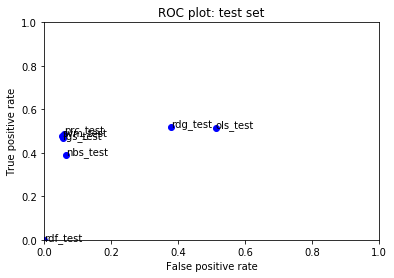

In [33]:
fits = [ols_performance_test, svm_performance_test, lgs_performance_test, nbs_performance_test, prc_performance_test, rdg_performance_test, rdf_performance_test]

for fit in fits:
    plt.plot(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
             fit.performance_measures['TP'] / fit.performance_measures['Pos'], 'bo')
    plt.text(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
             fit.performance_measures['TP'] / fit.performance_measures['Pos'], fit.desc)
plt.axis([0, 1, 0, 1])
plt.title('ROC plot: test set')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.show()

---

# <span style="color:red">SUBMISSION</span>

---

In [35]:
# read in test data for submission
# CHANGE FILE PATH and my_random_seed number (any integer other than 74 will do): 
raw_data, X_test_submission = process_raw_data(fn='/Users/toeyscn/Downloads/ml-master/final_assignment_1/toxiccomments_test.csv', my_random_seed=74, test=True)
print("Number of rows in the submission test set (should be 153,164): ")

toxic_data is: <class 'pandas.core.frame.DataFrame'>
toxic_data has 153164 rows and 2 columns 

the data types for each of the columns in toxic_data:
id              object
comment_text    object
dtype: object 

the first 10 rows in toxic_data:
                 id                                       comment_text
0  00001cee341fdb12  Yo bitch Ja Rule is more succesful then you'll...
1  0000247867823ef7  == From RfC == \n\n The title is fine as it is...
2  00013b17ad220c46  " \n\n == Sources == \n\n * Zawe Ashton on Lap...
3  00017563c3f7919a  :If you have a look back at the source, the in...
4  00017695ad8997eb          I don't anonymously edit articles at all.
Shape of HashingVectorizer X:
(153164, 131072)
Look at a few rows of the new quantitative features: 
   word_count  punc_count
0          72          10
1          13           1
2          16           0
3          38           3
4           7           1
5          16           2
6          31           4
7           6       

---

Choose a <span style="color:red">*single*</span> model for your submission. In this code, I am choosing the Ordinary Least Squares model fit, which is in the `ols` object. But you should choose the model that is performing the best for you! 

In [36]:
# store the id from the raw data
my_submission = pd.DataFrame(raw_data["id"])
# concatenate predictions to the id
my_submission["prediction"] = ols.predict(X_test_submission)
# look at the proportion of positive predictions
print(my_submission['prediction'].mean())

0.5163680760492022


In [37]:
raw_data.head()

,id,comment_text,word_count,punc_count
0,00001cee341fdb12,Yo bitch Ja Rule is more succesful then you'll...,72,10
1,0000247867823ef7,== From RfC == \n\n The title is fine as it is...,13,1
2,00013b17ad220c46,""" \n\n == Sources == \n\n * Zawe Ashton on Lap...",16,0
3,00017563c3f7919a,":If you have a look back at the source, the in...",38,3
4,00017695ad8997eb,I don't anonymously edit articles at all.,7,1


In [38]:
my_submission.head()

,id,prediction
0,00001cee341fdb12,True
1,0000247867823ef7,False
2,00013b17ad220c46,False
3,00017563c3f7919a,False
4,00017695ad8997eb,False


In [39]:
my_submission.shape

(153164, 2)

In [40]:
# export submission file as pdf
# CHANGE FILE PATH: 
my_submission.to_csv('/Users/toeyscn/Downloads/ml-master/final_assignment_1/toxiccomments_submission.csv', index=False)

# Submit to Canvas: 1) the CSV file that was written in the previous cell and 2) the url to the repository (GitHub or other) that contains your code and documentation